In [10]:
!pip install u8darts[all]==0.25.0

     |████████████████████████████████| 760 kB 1.5 MB/s eta 0:00:01    |▉                               | 20 kB 1.2 MB/s eta 0:00:01
  Attempting uninstall: u8darts
    Found existing installation: u8darts 0.27.0
    Uninstalling u8darts-0.27.0:
      Successfully uninstalled u8darts-0.27.0


In [1]:
from darts.datasets import WeatherDataset
from darts.models import LightGBMModel
from darts.utils.missing_values import missing_values_ratio, fill_missing_values
from darts import TimeSeries

In [2]:
import pandas as pd

In [ ]:
series = WeatherDataset().load()

In [ ]:
df = series.pd_dataframe()

In [ ]:
series_filled = fill_missing_values(series)
df_filled = series_filled.pd_dataframe()

In [3]:
#df = pd.read_csv('Weather.csv')

In [4]:
#df_filled = pd.read_csv('Weather_filled.csv')

In [5]:
df_filled['Date Time'] = pd.to_datetime(df_filled['Date Time'])

In [6]:
corr_matrix = df_filled.corr()
corr_matrix['p (mbar)'].sort_values()

max. wv (m/s)          -0.229423
Tpot (K)               -0.223278
Tdew (degC)            -0.207212
H2OC (mmol/mol)        -0.201153
sh (g/kg)              -0.200934
VPact (mbar)           -0.183739
Date Time              -0.151027
raining (s)            -0.135064
wd (deg)               -0.129401
T (degC)               -0.127112
VPmax (mbar)           -0.098765
Tlog (degC)            -0.082469
rain (mm)              -0.071901
rh (%)                 -0.068620
wv (m/s)               -0.010161
CO2 (ppm)              -0.003539
VPdef (mbar)           -0.002633
max. PAR (µmol/m²/s)    0.049507
PAR (µmol/m²/s)         0.068492
SWDR (W/m²)             0.074399
rho (g/m**3)            0.437317
p (mbar)                1.000000
Name: p (mbar), dtype: float64

In [7]:
col_list = ['p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)',
       'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
       'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)',
       'wd (deg)', 'rain (mm)', 'raining (s)', 'SWDR (W/m²)',
       'PAR (µmol/m²/s)', 'max. PAR (µmol/m²/s)', 'Tlog (degC)', 'CO2 (ppm)']

In [8]:
series_filled = TimeSeries.from_dataframe(df_filled, 'Date Time', col_list)

In [9]:
rho_normalized = (series_filled['rho (g/m**3)'] - series_filled['rho (g/m**3)'].values().min())/(series_filled['rho (g/m**3)'].values().max() - series_filled['rho (g/m**3)'].values().min())

target_normalized = (series_filled['p (mbar)'] - series_filled['p (mbar)'].values().min())/(series_filled['p (mbar)'].values().max() - series_filled['p (mbar)'].values().min())


<Axes: xlabel='Date Time'>

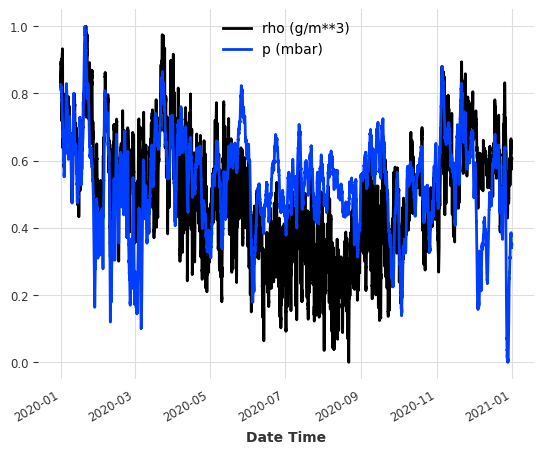

In [10]:
rho_normalized.plot() # MTR
target_normalized.plot()

In [11]:
num_test = 6*24 # granularity is 10 mins so 6*24 is one day.
output_chunk_len = 6*1 # one hour: how many samples to predcit with each .predict()

if output_chunk_len == num_test:
    num_forecast_rolls = 1
else:
    num_forecast_rolls = int(num_test/output_chunk_len)


In [12]:
num_samples_selected_for_train_and_test = 6*24*31
series_filled_selected = series_filled[:num_samples_selected_for_train_and_test]

In [13]:
target_series = series_filled_selected['p (mbar)']
past_covariates = series_filled_selected['rain (mm)']
future_cov = series_filled_selected['T (degC)']

target_series_train, target_series_test = target_series[:-num_test], target_series[-num_test:]
#past_covariates_train, past_covariates_test = past_covariates[:-num_test], past_covariates[-num_test:]
#future_cov_train, future_cov_test = future_cov[:-num_test], future_cov[-num_test:]

# lags_past_covariates=output_chunk_len, lags_future_covariates=[0,1,2,3,4,5],



In [14]:
from darts import TimeSeries
import numpy as np


In [15]:
num_forecast_rolls

24

In [16]:
len(target_series_train)/24/6

30.0

In [17]:
#all_preds = TimeSeries.from_values(np.array([])) # Did not work!
all_preds = [] # TODO: this has to be replaced with a TimeSeries as opposed to a raw list

for curr_roll in range(num_forecast_rolls):
    print('curr_roll=', curr_roll)

    curr_roll_model = LightGBMModel(
    lags=output_chunk_len,
    output_chunk_length=output_chunk_len,
    verbose=-1,
     n_jobs=-1
    )

    if curr_roll == 0:
        target_series_train_for_this_roll = target_series_train
    else:
        try:

            target_series_to_be_appended = target_series_test[
              (curr_roll-1)*output_chunk_len:(curr_roll-1)*output_chunk_len+output_chunk_len
              ]

            # TODO: Why do i keep getting error when using append instead of append values?
            # append would be much safer (making sure indicies are not messed up!) than current append_values.
            target_series_train_for_this_roll = target_series_train_for_this_roll.append_values(
              target_series_to_be_appended.values()
              )
        except:
            print('curr_roll=', curr_roll)
            print('target_series_to_be_appended', target_series_to_be_appended.time_index)
            print('target_series_train_for_this_roll', target_series_train_for_this_roll.time_index)
            assert(False)


    curr_roll_model.fit(target_series_train_for_this_roll)
    curr_roll_preds = curr_roll_model.predict(output_chunk_len)
    all_preds.append(list(curr_roll_preds.values().flatten()))

curr_roll= 0
curr_roll= 1
curr_roll= 2
curr_roll= 3
curr_roll= 4
curr_roll= 5
curr_roll= 6
curr_roll= 7
curr_roll= 8
curr_roll= 9
curr_roll= 10
curr_roll= 11
curr_roll= 12
curr_roll= 13
curr_roll= 14
curr_roll= 15
curr_roll= 16
curr_roll= 17
curr_roll= 18
curr_roll= 19
curr_roll= 20
curr_roll= 21
curr_roll= 22
curr_roll= 23


<Axes: xlabel='Date Time'>

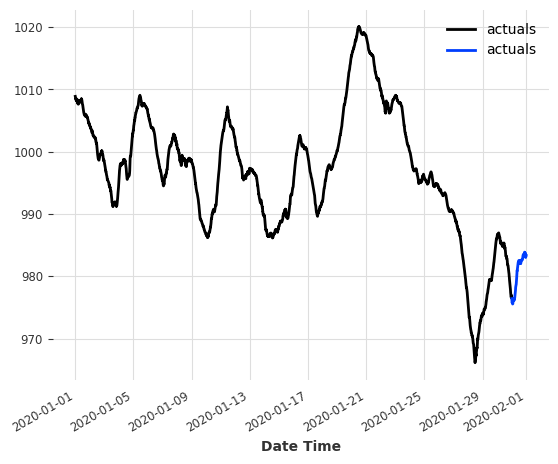

In [37]:
#pred.plot(label='preds')
target_series_train.plot(label='actuals')
target_series_test.plot(label='actuals')



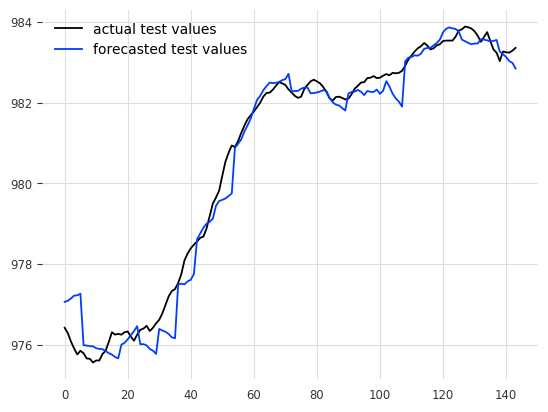

In [19]:
import matplotlib.pyplot as plt
plt.plot(target_series_test.values().flatten(), label='actual test values')
plt.plot(np.array(all_preds).flatten(), label='forecasted test values')
plt.legend()

### RNN

In [40]:
len(target_series_train)

4320

In [20]:
from darts.models import RNNModel

In [21]:
from pytorch_lightning.callbacks import Callback

class LossLogger(Callback):
    def __init__(self):
        self.train_loss = []
        self.val_loss = []

    # will automatically be called at the end of each epoch
    def on_train_epoch_end(self, trainer: "pl.Trainer", pl_module: "pl.LightningModule") -> None:
        self.train_loss.append(float(trainer.callback_metrics["train_loss"]))

    '''
    def on_validation_epoch_end(self, trainer: "pl.Trainer", pl_module: "pl.LightningModule") -> None:
        self.val_loss.append(float(trainer.callback_metrics["val_loss"]))
    '''


loss_logger = LossLogger()
'''
model = SomeTorchForecastingModel(
    ...,
    nr_epochs_val_period=1,  # perform validation after every epoch
    pl_trainer_kwargs={"callbacks": [loss_logger]}
)

# fit must include validation set for "val_loss"
model.fit(...)
'''


'\nmodel = SomeTorchForecastingModel(\n    ...,\n    nr_epochs_val_period=1,  # perform validation after every epoch\n    pl_trainer_kwargs={"callbacks": [loss_logger]}\n)\n\n# fit must include validation set for "val_loss"\nmodel.fit(...)\n'

In [22]:
try:
    del rnn_model
    del fitted_model
except:
    pass

In [23]:
rnn_model

NameError: name 'rnn_model' is not defined

In [41]:


import torch

rnn_model = RNNModel(
    model="LSTM",
    dropout=0,
    optimizer_kwargs={"lr": 1e-2},
    model_name="Weather_RNN",
    log_tensorboard=True,
    random_state=42,
    training_length=2*output_chunk_len, #TODO
    input_chunk_length=output_chunk_len,
    force_reset=True,
    save_checkpoints=False,
    pl_trainer_kwargs={"callbacks": [loss_logger]},
    lr_scheduler_cls=torch.optim.lr_scheduler.ExponentialLR,
    lr_scheduler_kwargs={"gamma": 0.09}
)


In [42]:
'''
TODO:
Setting training_length? Darts say: The length of both input (target and covariates)
and output (target) time series used during training. Generally speaking, `training_length`
should have a higher value than `input_chunk_length` because otherwise during training the RNN
is never run for as many iterations as it will during inference.
For more information on this parameter, please see `darts.utils.data.ShiftedDataset`
'''

'\nTODO:\nSetting training_length? Darts say: The length of both input (target and covariates)\nand output (target) time series used during training. Generally speaking, `training_length`\nshould have a higher value than `input_chunk_length` because otherwise during training the RNN\nis never run for as many iterations as it will during inference.\nFor more information on this parameter, please see `darts.utils.data.ShiftedDataset`\n'

In [43]:
%%time
fitted_model = rnn_model.fit(target_series_train)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 2.8 K 
4 | V             | Linear           | 26    
---------------------------------------------------
2.8 K     Trainable params
0         Non-trainable params
2.8 K     Total params
0.011     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


CPU times: user 5min 29s, sys: 10.4 s, total: 5min 39s
Wall time: 3min 50s


In [44]:
fitted_model

RNNModel(model=LSTM, hidden_dim=25, n_rnn_layers=1, dropout=0, training_length=12, optimizer_kwargs={'lr': 0.01}, model_name=Weather_RNN, log_tensorboard=True, random_state=42, input_chunk_length=6, force_reset=True, save_checkpoints=False, pl_trainer_kwargs={'callbacks': [<__main__.LossLogger object at 0x7f8728539dc0>]}, lr_scheduler_cls=<class 'torch.optim.lr_scheduler.ExponentialLR'>, lr_scheduler_kwargs={'gamma': 0.09})

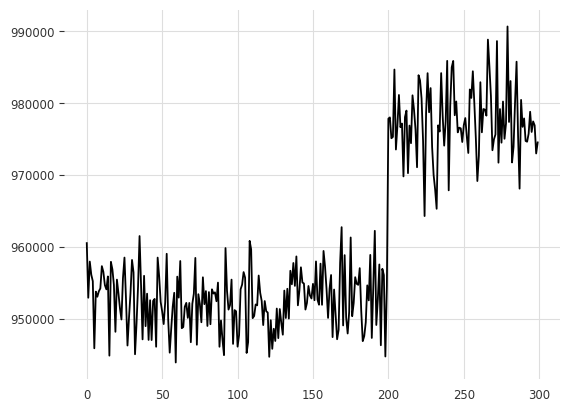

In [45]:
plt.plot(loss_logger.train_loss[:])

In [46]:
rnn_preds = rnn_model.predict(num_test)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

In [1]:
rnn_preds.plot()
target_series_test.plot(label='actuals_test')

NameError: name 'rnn_preds' is not defined

<Axes: xlabel='Date Time'>

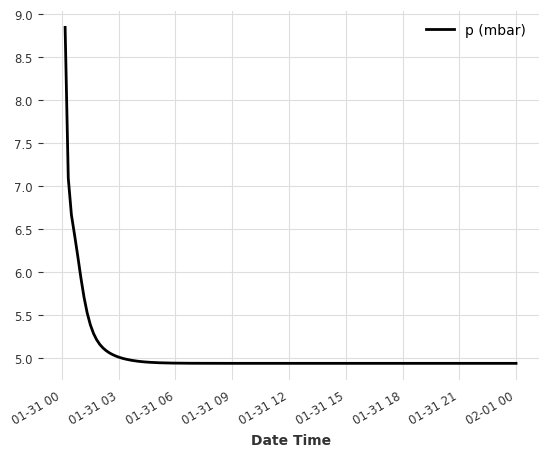

In [47]:
rnn_preds.plot()

<Axes: xlabel='Date Time'>

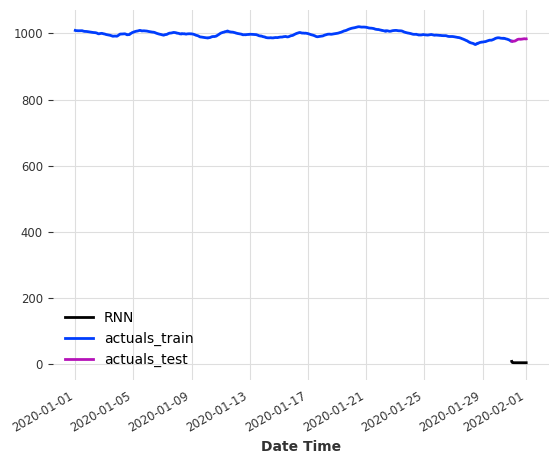

In [48]:
rnn_preds.plot(label='RNN')
target_series_train.plot(label='actuals_train')
target_series_test.plot(label='actuals_test')
